This script describes how we prioritized pdTFs and pdCREs based on the in-silico perturbation results, and how to draw the transitional graph among states

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from pyfaidx import Fasta
from verstack import stratified_continuous_split
import matplotlib.pyplot as plt
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import scipy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torchvision import datasets
from torcheval.metrics.functional import multiclass_f1_score
from torch_geometric.nn import GCNConv

import h5py
import seaborn as sns
import os
os.chdir('/nfs/public/xixi/scRegulate/T2D')

from typing import Tuple
import scanpy as sc
sc.settings.set_figure_params(dpi=80, facecolor='white')
from collections import Counter

# Data and model preparation

In [2]:
df_x = pd.read_csv('./data/beta.atac.aggregate_30cells.csv', index_col=0).transpose()
df_x

,10-100001665-100002165,10-100002531-100003031,10-100003836-100004336,10-100005433-100005933,10-100006548-100007048,10-100013839-100014339,10-100018334-100018834,10-100019564-100020064,10-100020408-100020908,10-100021589-100022089,...,Y-8756349-8756849,Y-8861982-8862482,Y-8869228-8869728,Y-8894760-8895260,Y-8895712-8896212,Y-8902164-8902664,Y-8903250-8903750,Y-9490312-9490812,Y-9647600-9648100,Y-9649551-9650051
V1,0.000000,0.0,0.00000,0.468211,0.468211,0.936421,0.000000,0.468211,0.468211,0.468211,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V2,0.000000,0.0,0.00000,0.000000,0.468040,0.468040,0.000000,0.000000,0.468040,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V3,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.627410,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V4,0.565643,0.0,0.00000,0.000000,0.565643,0.000000,1.131286,0.896523,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V5,0.000000,0.0,0.00000,0.000000,0.000000,0.484623,0.000000,0.484623,0.000000,0.484623,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1390,0.000000,0.0,0.00000,0.658323,0.000000,1.043417,0.000000,0.658323,0.658323,0.658323,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V1391,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V1392,0.000000,0.0,0.00000,0.000000,0.000000,0.910113,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.910113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V1393,0.630010,0.0,0.63001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_y = pd.read_csv('./data/beta.rna.aggregate_30cells.csv', index_col=0).transpose()
df_y

,WASH7P,RP11-34P13.7,RP11-34P13.10,AL627309.1,RP11-34P13.13,RP11-34P13.9,AP006222.2,RP11-206L10.17,RP5-857K21.2,RP5-857K21.9,...,CH507-513H4.6,CH17-408M7.1,CH507-39O4.1,CH507-39O4.2,CH507-24F1.1,CH507-338C24.1,CH507-254M2.3,CH507-154B10.2,CH507-145C22.3,CH17-351M24.1
V1,0.0,0.515306,0.0,0.515306,0.515306,0.0,0.515306,1.446647,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.515306,0.816741,0.0,0.000000
V2,0.0,0.494710,0.0,0.494710,0.784097,0.0,0.494710,0.784097,0.0,0.0,...,0.0,0.000000,0.0,0.494710,0.000000,1.278808,0.784097,1.148682,0.0,0.494710
V3,0.0,0.000000,0.0,0.000000,0.629183,0.0,0.000000,0.997232,0.0,0.0,...,0.0,0.000000,0.0,0.629183,0.000000,1.460918,0.629183,0.629183,0.0,0.000000
V4,0.0,0.610912,0.0,0.968272,0.610912,0.0,0.000000,0.968272,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.610912,1.418493,0.000000,0.0,0.000000
V5,0.0,0.499200,0.0,0.000000,0.000000,0.0,0.499200,1.159107,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,1.159107,0.499200,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1390,0.0,0.000000,0.0,0.000000,0.666096,0.0,1.055737,1.869967,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,1.546626,0.666096,1.055737,0.0,0.000000
V1391,0.0,1.166952,0.0,0.736265,0.000000,0.0,1.472530,2.333904,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,1.166952,0.736265,0.000000,0.0,0.000000
V1392,0.0,0.000000,0.0,0.788265,0.000000,0.0,1.830293,1.249370,0.0,0.0,...,0.0,0.788265,0.0,0.000000,0.000000,0.788265,1.576529,0.788265,0.0,0.000000
V1393,0.0,0.000000,0.0,0.505620,0.505620,0.0,1.011240,0.505620,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,1.011240,0.505620,0.000000,0.0,0.000000


In [4]:
df_peaks = pd.DataFrame(df_x.columns)[0].str.split('-',expand=True) 
df_peaks = df_peaks.rename(columns={0: "chrom", 1: "start", 2: "end"})
df_peaks["start"] = pd.to_numeric(df_peaks["start"])
df_peaks["end"] = pd.to_numeric(df_peaks["end"])
df_peaks

,chrom,start,end
0,10,100001665,100002165
1,10,100002531,100003031
2,10,100003836,100004336
3,10,100005433,100005933
4,10,100006548,100007048
...,...,...,...
412092,Y,8902164,8902664
412093,Y,8903250,8903750
412094,Y,9490312,9490812
412095,Y,9647600,9648100


In [5]:
#df_peaks.to_csv('/data1/xixi/scRegulate/multiomic_data/10x_PBMC/peaks_all.csv')

In [6]:
geneanno = pd.read_csv('../../ref_genome/hg19_geneanno.txt', sep='\t')
geneanno = geneanno.drop_duplicates(subset=['Gene name'])
geneanno

,Gene stable ID,Transcript stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Transcription start site (TSS)
0,ENSG00000271782,ENST00000607815,1,50902700,50902978,-1,RP5-850O15.4,50902978
1,ENSG00000232753,ENST00000424955,1,103817769,103828355,1,RP11-347K2.1,103817769
2,ENSG00000225767,ENST00000424664,1,50927141,50936822,1,RP5-850O15.3,50927141
3,ENSG00000202140,ENST00000365270,1,50965430,50965529,-1,Y_RNA,50965529
4,ENSG00000207194,ENST00000384465,1,51048076,51048183,1,RNU6-1026P,51048076
...,...,...,...,...,...,...,...,...
179049,ENSG00000229926,ENST00000442569,9,141031547,141038316,1,RP11-424E7.3,141031547
179050,ENSG00000159247,ENST00000503395,9,141044565,141071821,1,TUBBP5,141044565
179053,ENSG00000237419,ENST00000428088,9,141090383,141093775,-1,RP11-885N19.6,141093775
179054,ENSG00000233013,ENST00000446912,9,141106637,141143444,1,FAM157B,141107518


In [7]:
motif_files = os.listdir('../../ref_genome/JASPAR_motifs_pfm_homosapiens/pfm.np')
motif_files[:5]

['MA0002.1.RUNX1.npy',
 'MA0003.4.TFAP2A.npy',
 'MA0007.2.AR.npy',
 'MA0014.3.PAX5.npy',
 'MA0009.2.TBXT.npy']

In [8]:
tfs_kept = []
tf_by_region_mat = []
for i in list(motif_files):
    tf = i.split('.')[-2]#.capitalize()
    if tf in df_y.columns:
        if tf in tfs_kept:
            continue
            
        tfs_kept.append(tf)
tfs_kept = sorted(tfs_kept)

In [9]:
y = pd.read_csv('./data/beta.label.aggregate_30cells.csv', index_col=0)

y = y['status'].to_list()

In [10]:
y_label_train, y_label_test = train_test_split(y, test_size=0.3,random_state=2024, stratify=y)
y_label_test, y_label_val = train_test_split(y_label_test, test_size=0.5, random_state=2024,stratify=y_label_test)

# pdTF prioritization

## Upregulation

In [11]:
results = np.load('./predict_status/interpret/input_output_TF_0.9quantile.GCN.string.npy')
results.shape

(10, 209, 457, 3)

In [12]:
#cls = {'Non-diabetic':0, 'Pre-T2D':1, 'T2D':2}
#from collections import Counter
import scipy.stats as ss
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(tfs_kept))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = 20
top_tfs_ind = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest
print([tfs_kept[i] for i in top_tfs_ind])
top_over = [tfs_kept[i] for i in top_tfs_ind]

['GLIS3', 'RORA', 'RFX3', 'MEIS2', 'FOS', 'HES1', 'FOXP2', 'MLXIPL', 'ETV1', 'NR1D2', 'TRPS1', 'HNF4A', 'PBX3', 'BACH2', 'BACH1', 'TCF4', 'JUND', 'TEAD1', 'KLF6', 'ZKSCAN1']


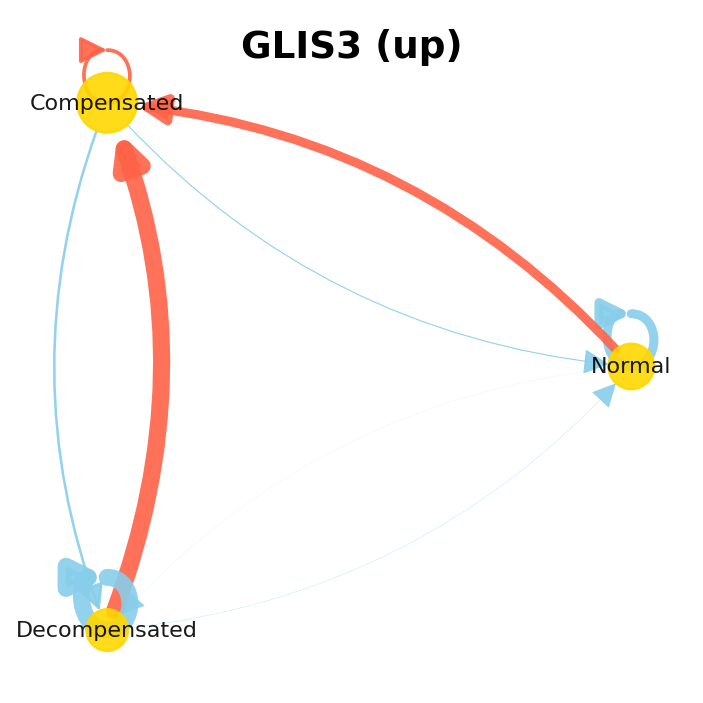

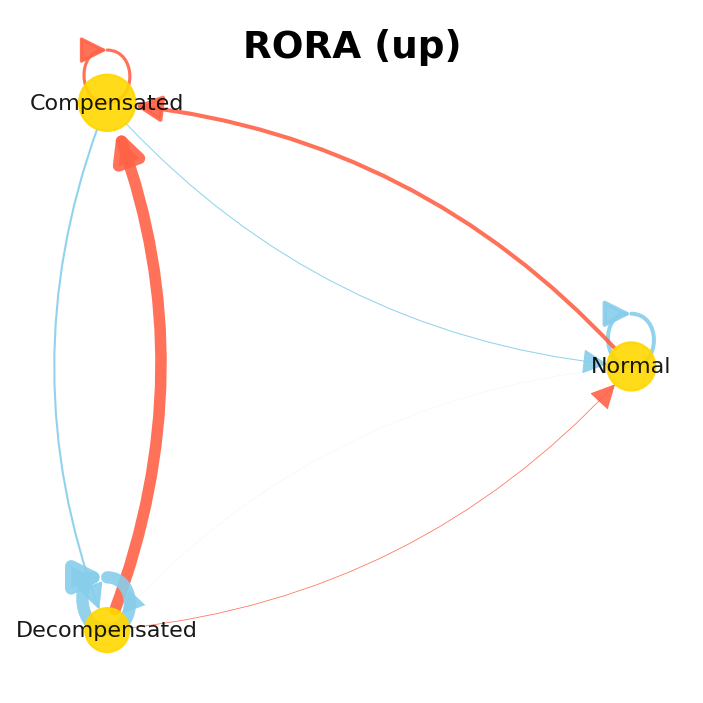

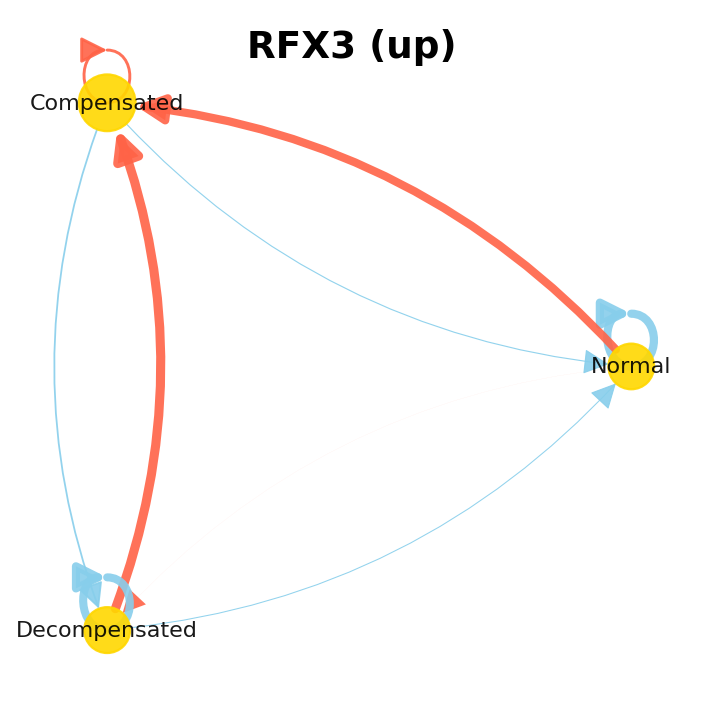

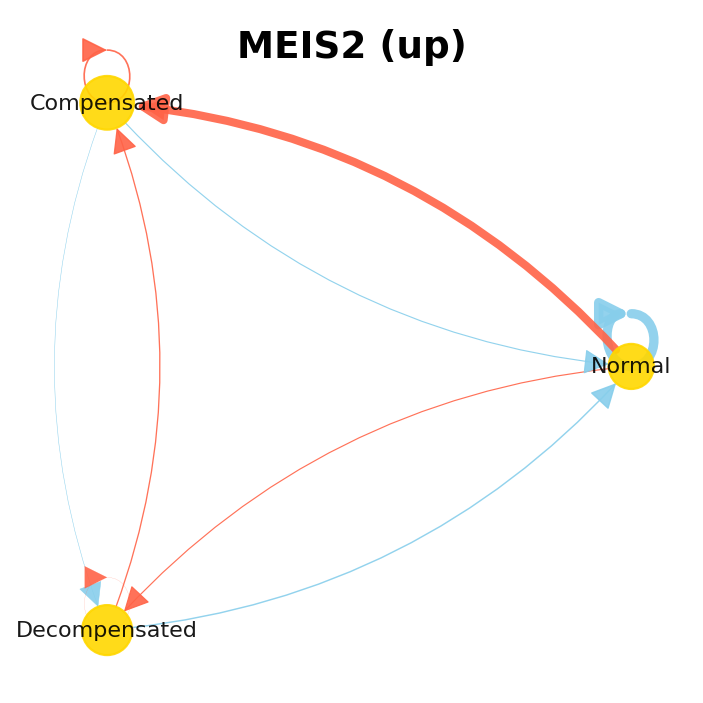

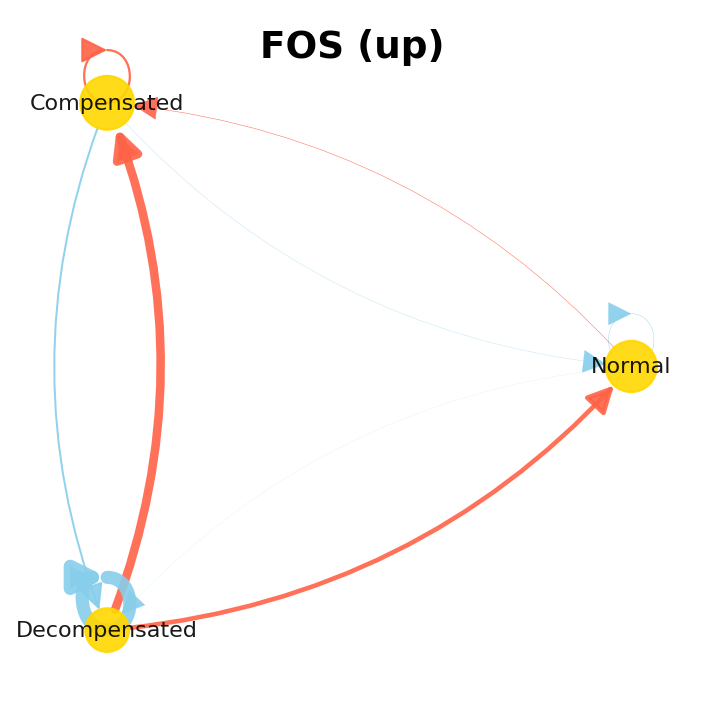

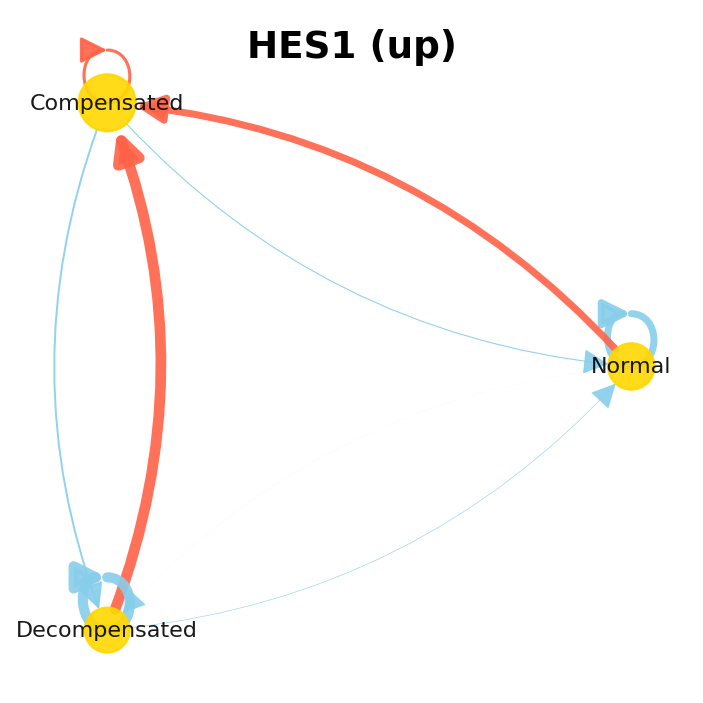

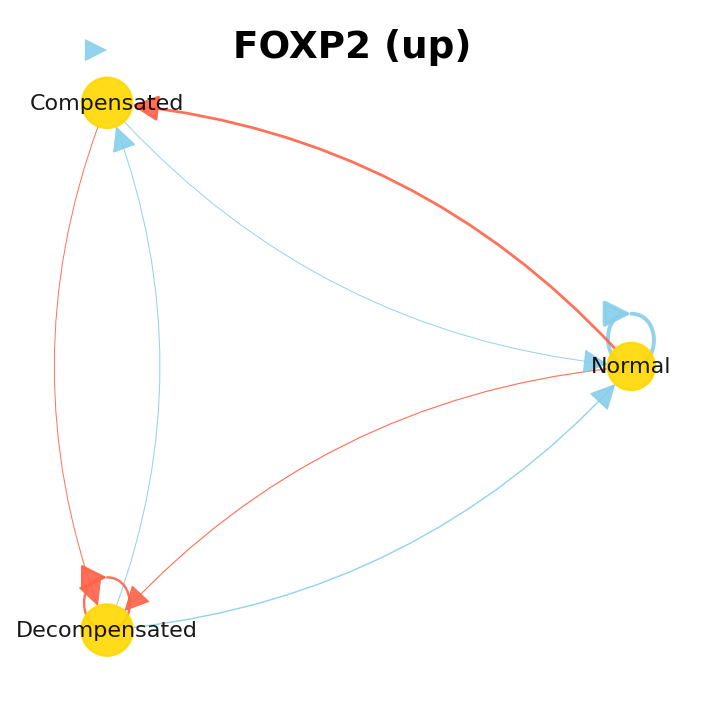

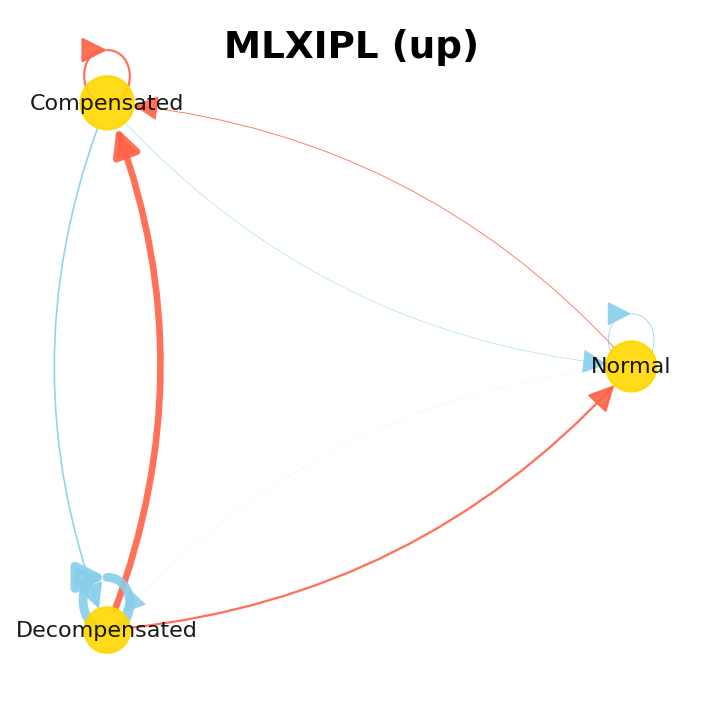

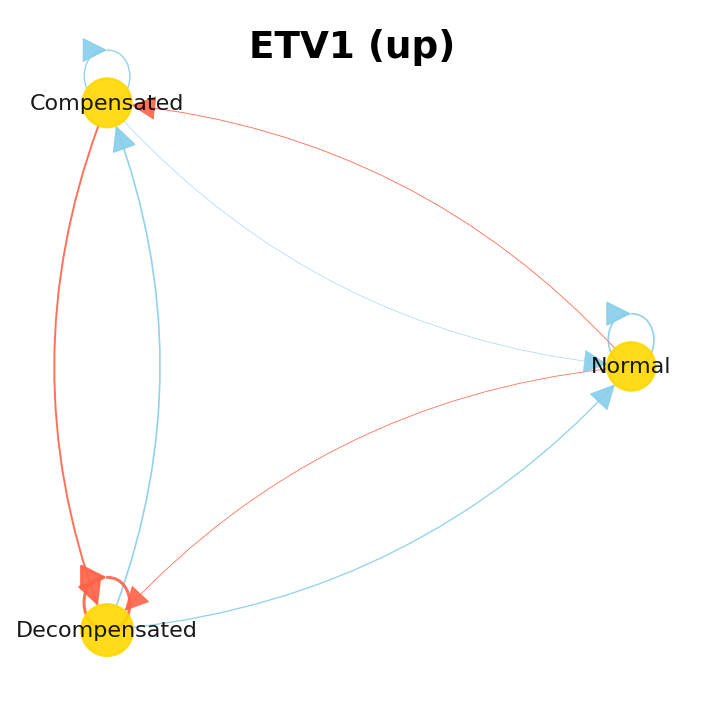

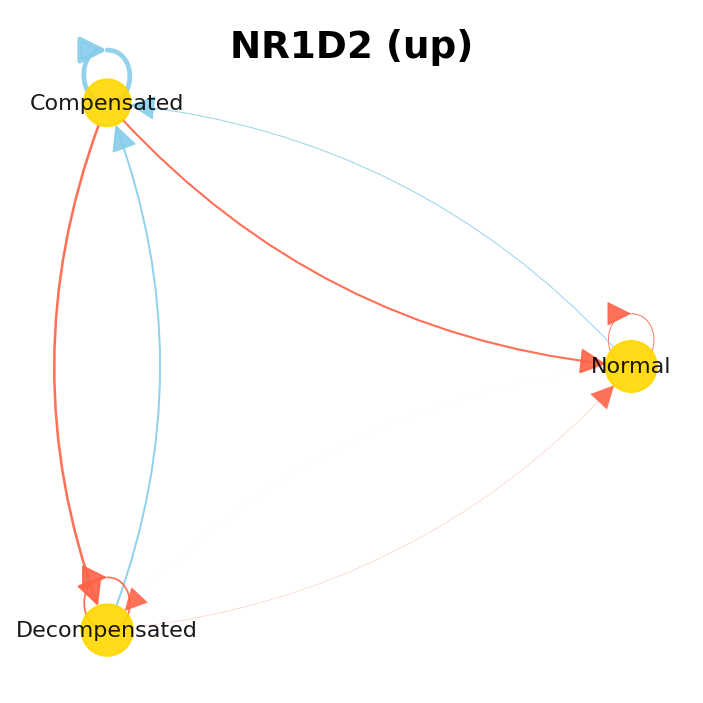

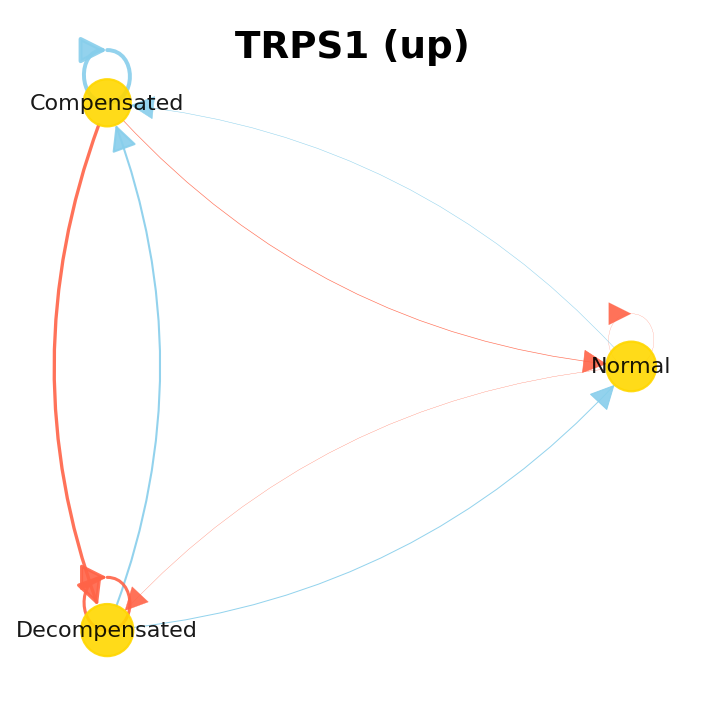

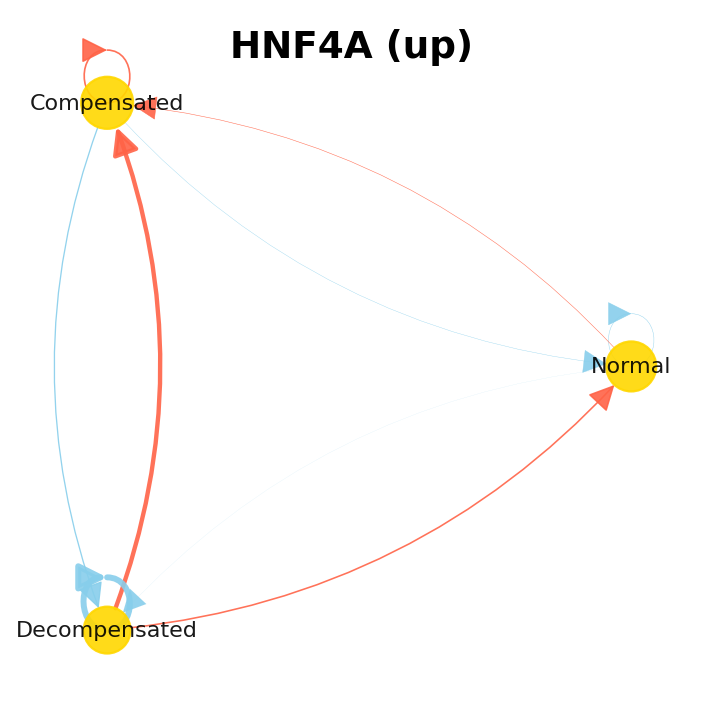

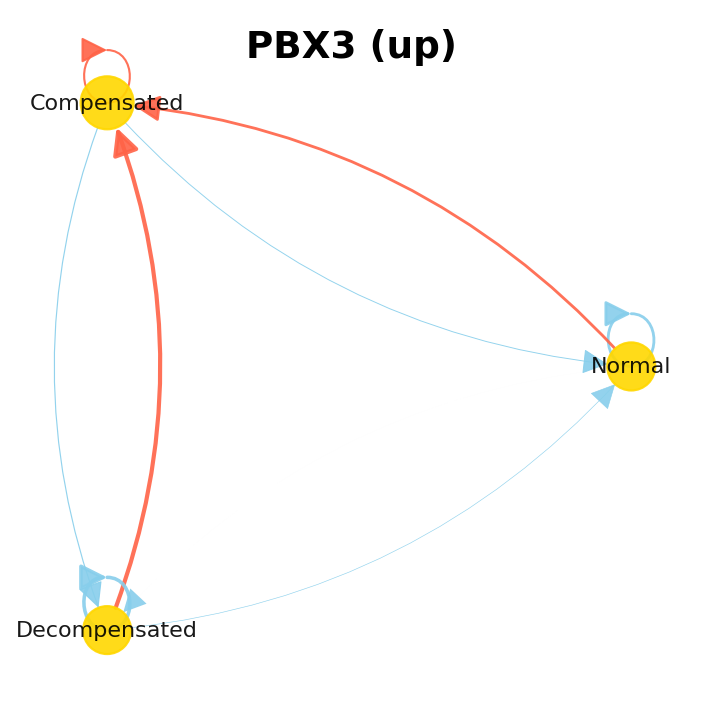

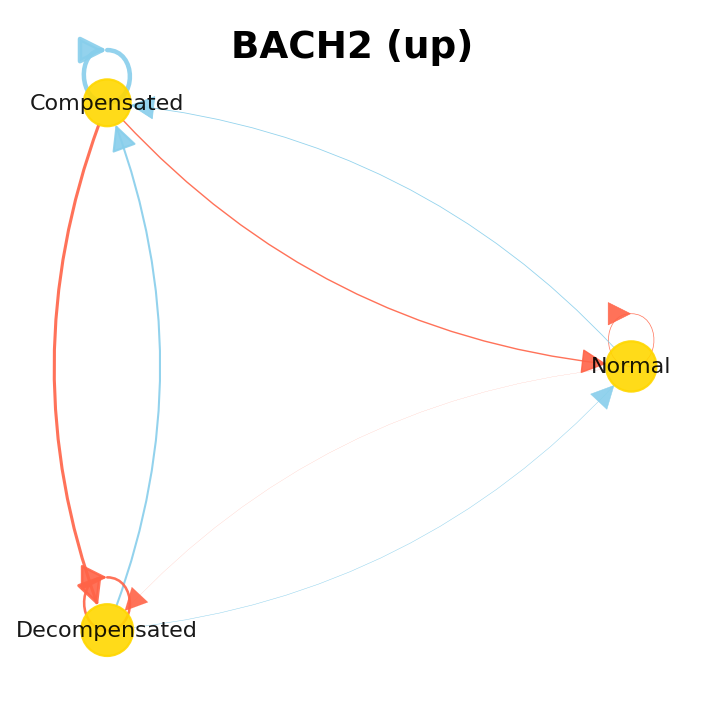

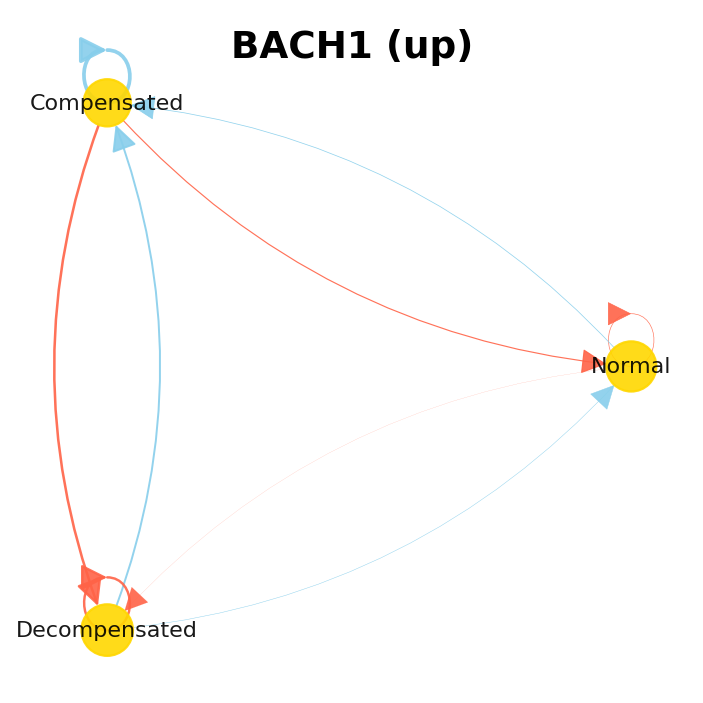

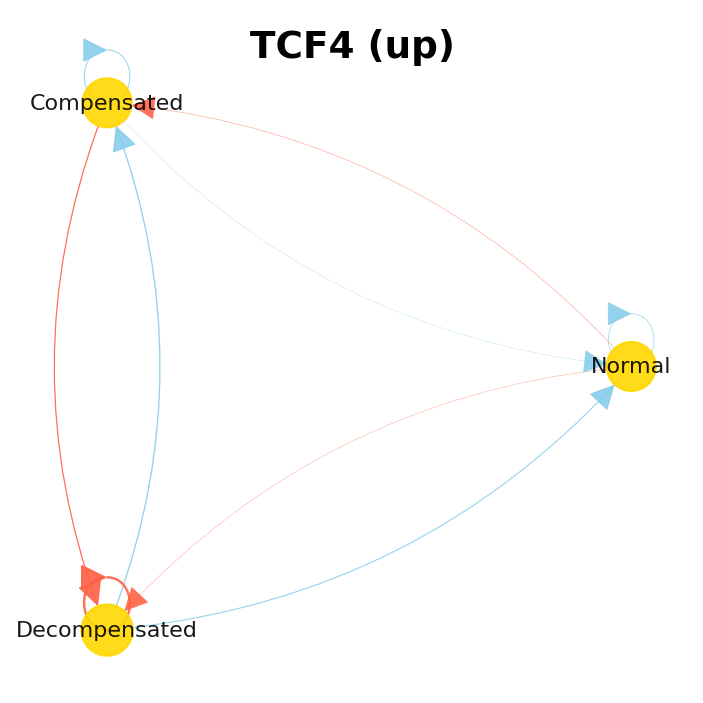

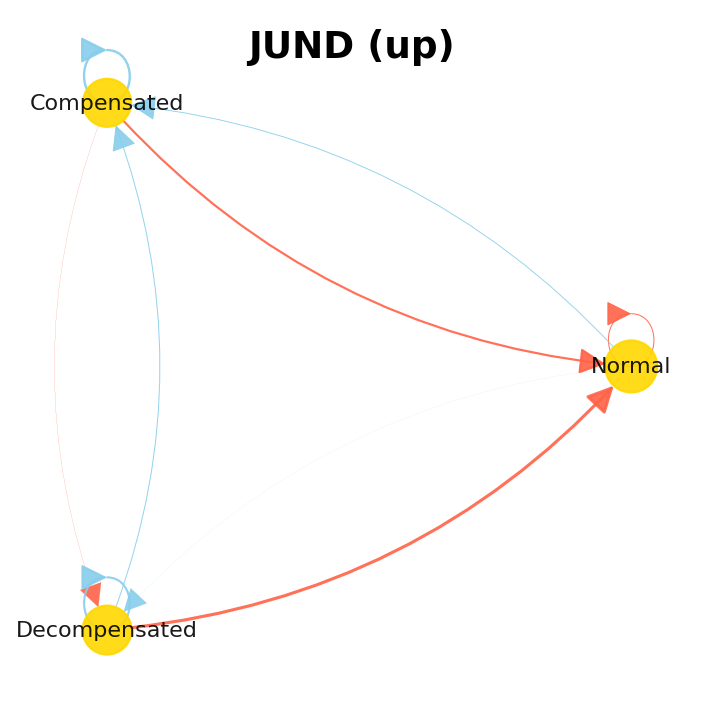

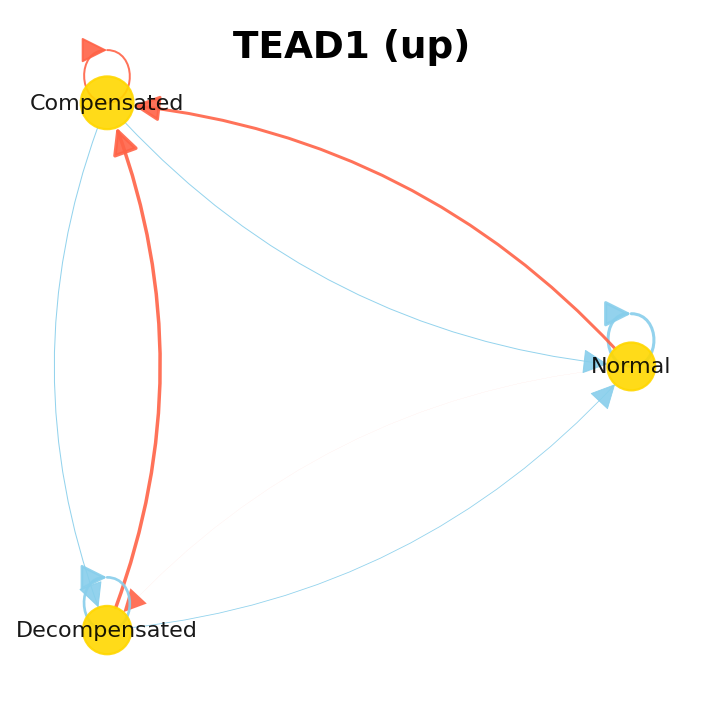

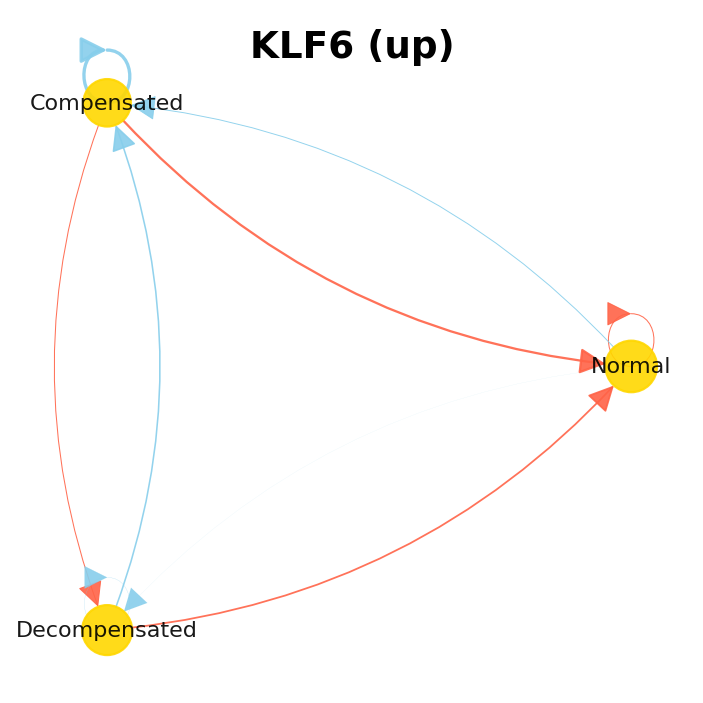

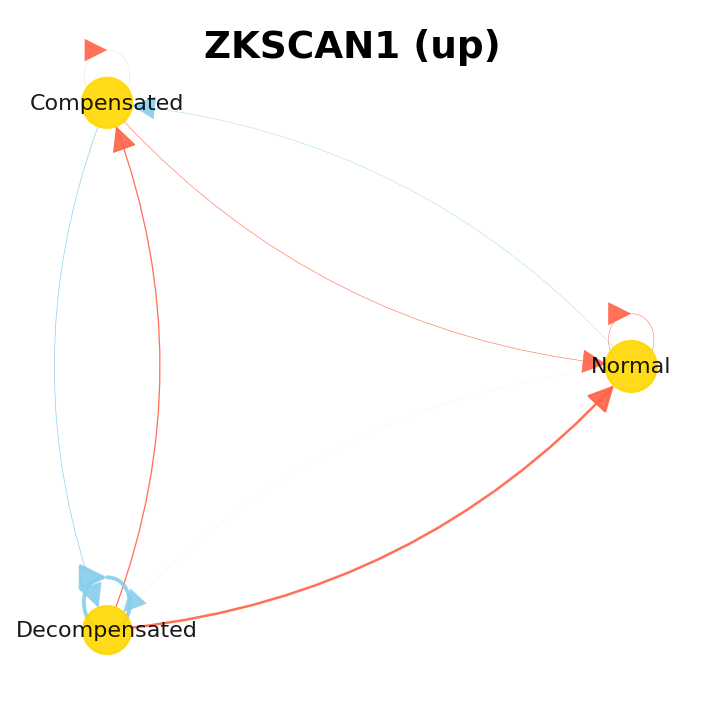

In [17]:
cls = {0:'Non-diabetic', 1:'Pre-T2D', 2:'T2D'}

rep = 0
cells = results[rep, :, :, :]
inds = top_tfs_ind
rank = 1
for ind in inds:
    mat = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            mat[i, j] = np.mean(cells[np.array(y_label_test)==cls[i], ind, j])

    tf = tfs_kept[ind]

    import matplotlib.pyplot as plt
    import networkx as nx
    plt.figure(figsize=(4.2,4.2))
    #plt.gcf().set_size_inches(5, 5)
    G = nx.DiGraph()
    states = ['Normal', 'Compensated', 'Decompensated']
    G.add_nodes_from(states)

    # 添加带权重的边，权重代表转移概率
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            G.add_edge(states[i], states[j], weight=mat[i,j])

    # 获取边的权重值和颜色
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    edge_colors = ['tomato' if weight >= 0 else 'skyblue' for weight in edge_weights]
    width = [abs(weight)*30 for weight in edge_weights]
    node_size=[np.sum(mat[i,:] + mat[:,i]) for i in range(3)]

    # 定义节点颜色
    node_colors = ['gold' for state in G.nodes]

    # 绘制图形
    pos = nx.circular_layout(G, scale=1)
    nx.draw(G, pos, with_labels=True, 
            node_color=node_colors, 
            node_size = [500*i+500 for i in node_size],
            width=width, 
            edge_color=edge_colors, connectionstyle="arc3,rad=0.2",
            font_size=10, font_color='black', alpha=0.9, arrowsize=25)

    plt.suptitle(tf+' (up)', fontweight='bold')
    plt.savefig('/nfs/public/xixi/scRegulate/figures/supp_fig1/'+str(rank)+'_'+tf+'.pdf')
    plt.show()
    plt.close()
    rank += 1

## Knockout 

In [18]:
results = np.load('./predict_status/interpret/input_output_TF*0.GCN.string.npy')
results.shape

(10, 209, 457, 3)

In [19]:
#cls = {'Non-diabetic':0, 'Pre-T2D':1, 'T2D':2}
#from collections import Counter
import scipy.stats as ss
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(tfs_kept))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = 20
top_tfs_ind = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest
print([tfs_kept[i] for i in top_tfs_ind])
top_over = [tfs_kept[i] for i in top_tfs_ind]

['GLIS3', 'RFX3', 'RORA', 'MEIS2', 'FOXP2', 'ETV1', 'NR1D2', 'HES1', 'TRPS1', 'BACH1', 'FOS', 'MLXIPL', 'BACH2', 'TCF4', 'PBX3', 'TEAD1', 'ETV5', 'CUX1', 'KLF6', 'FOXO3']


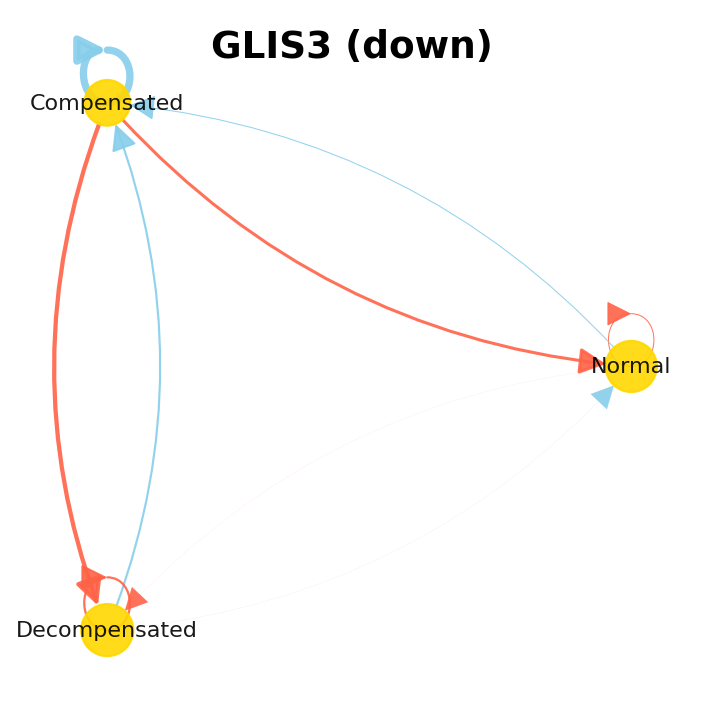

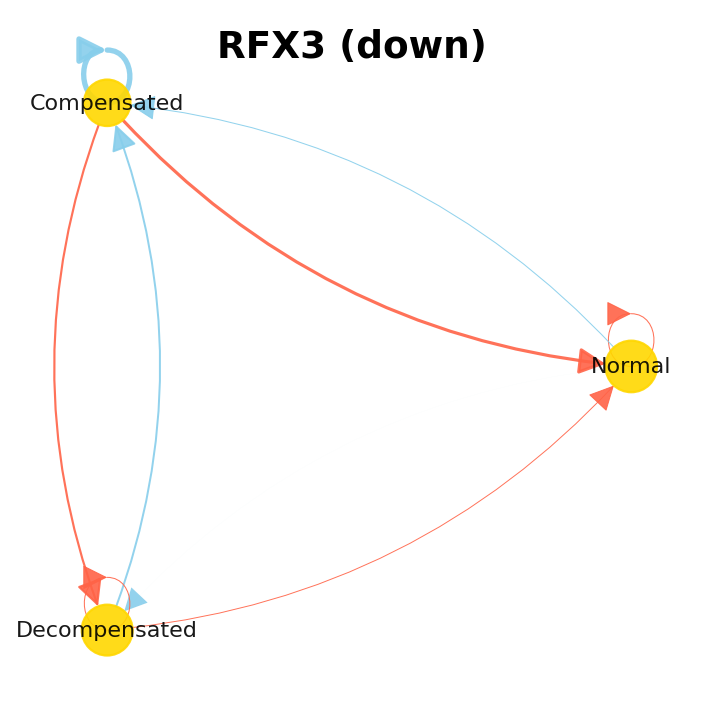

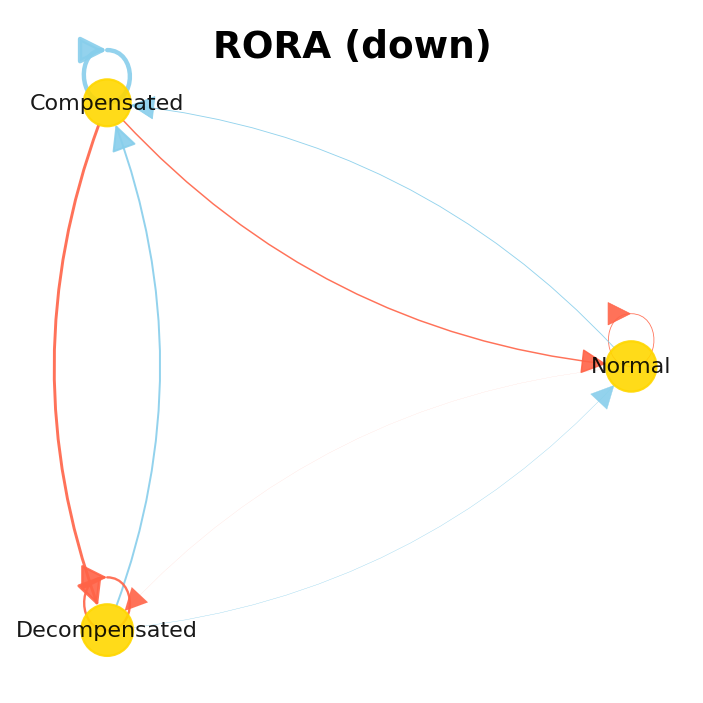

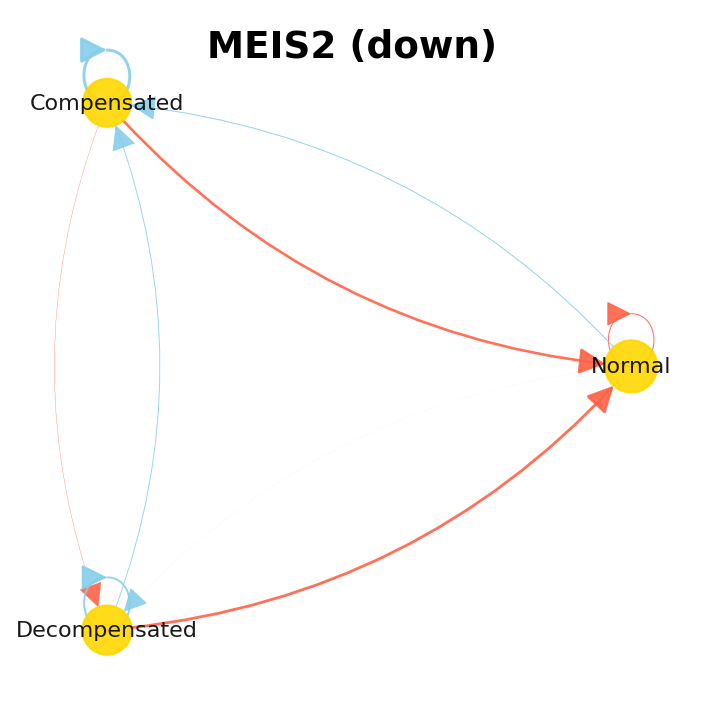

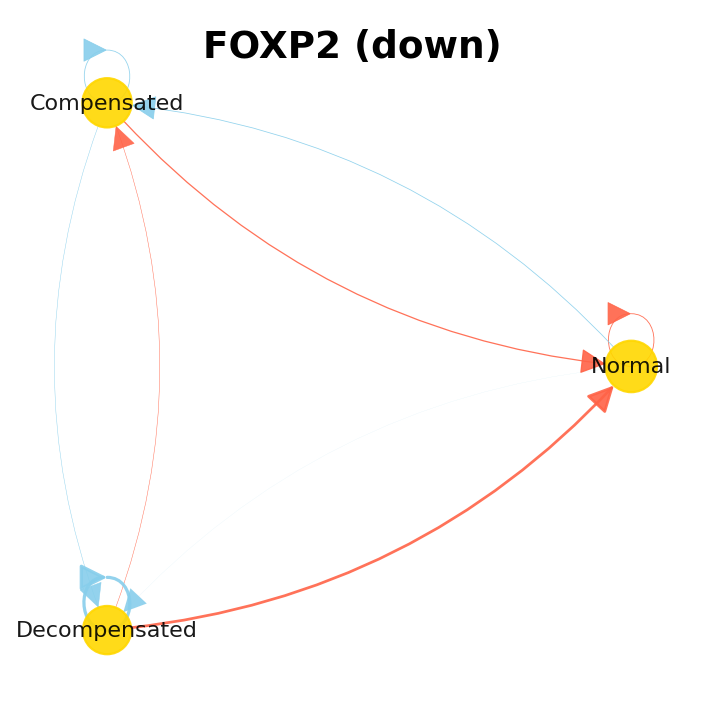

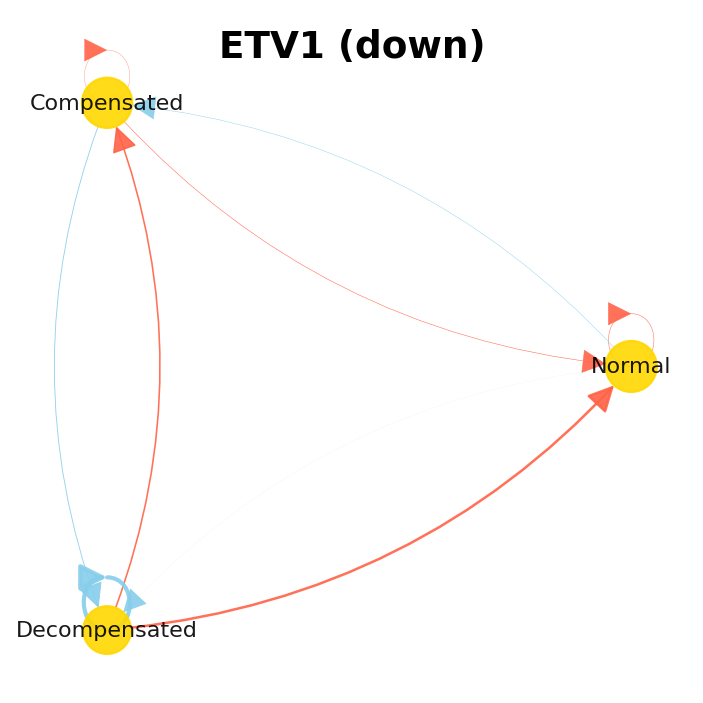

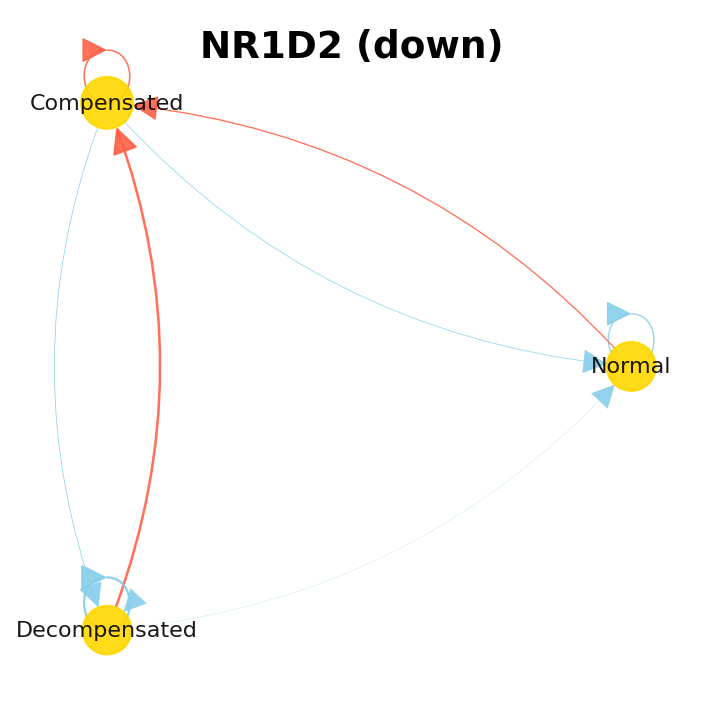

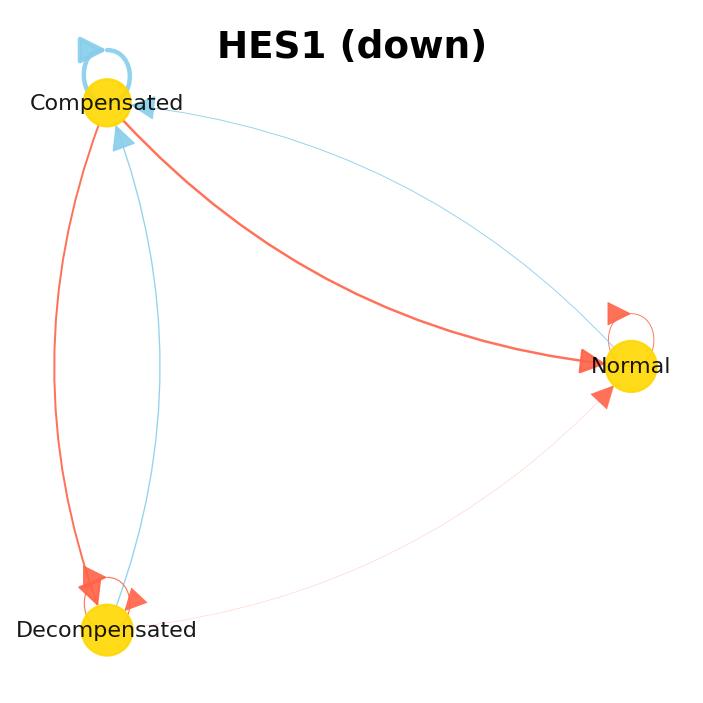

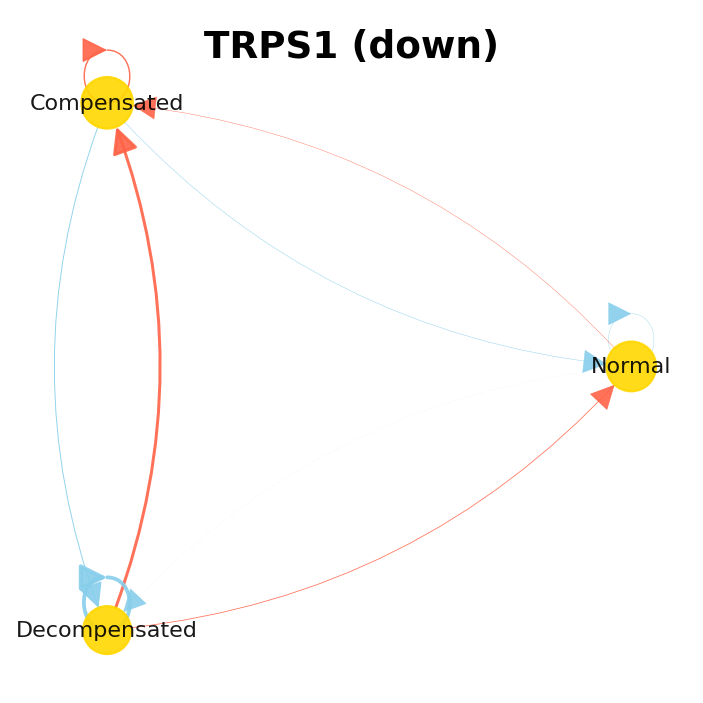

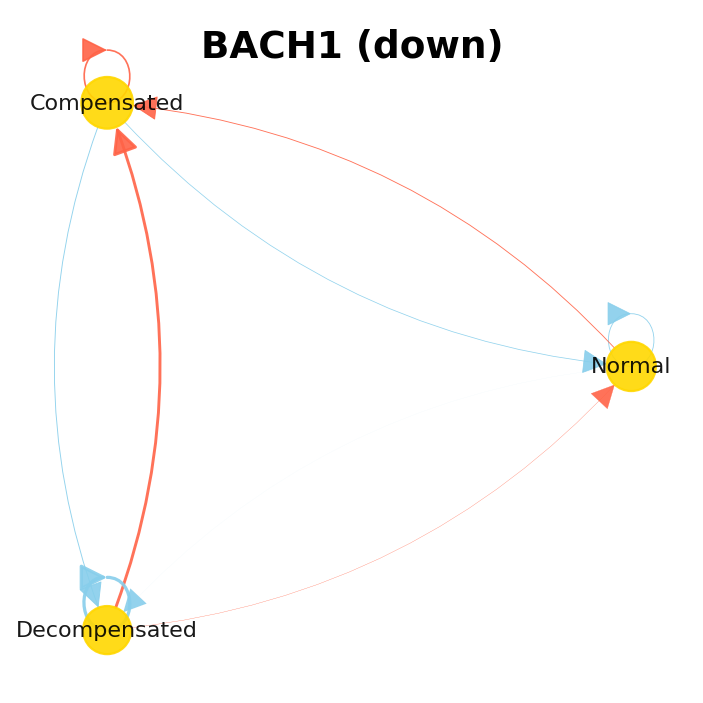

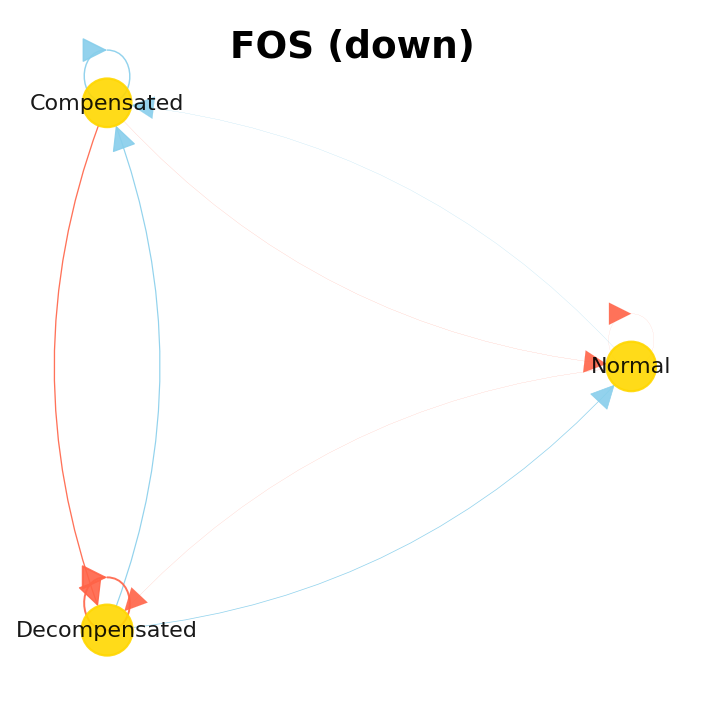

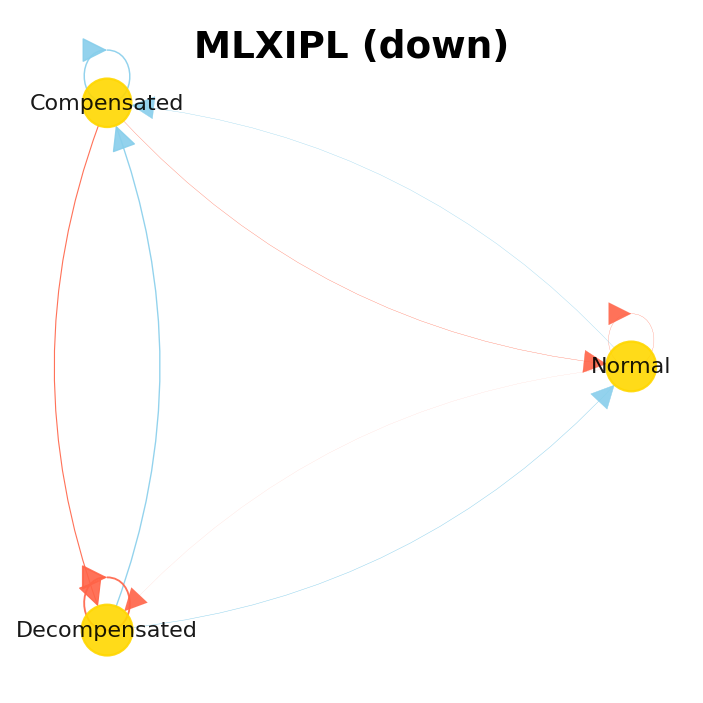

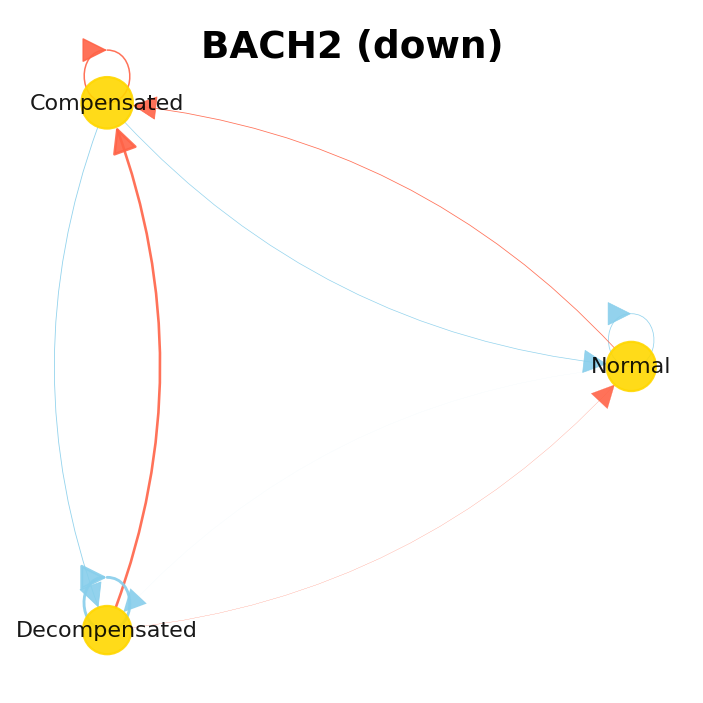

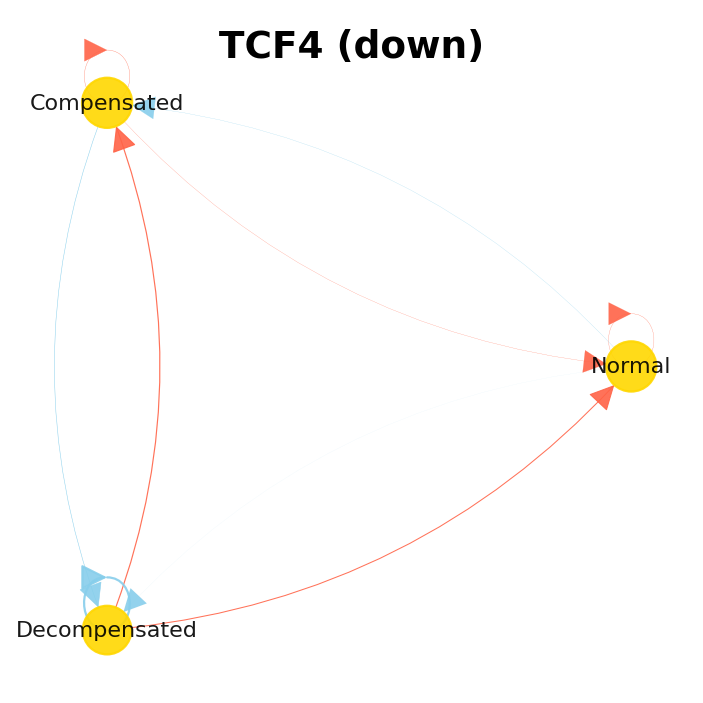

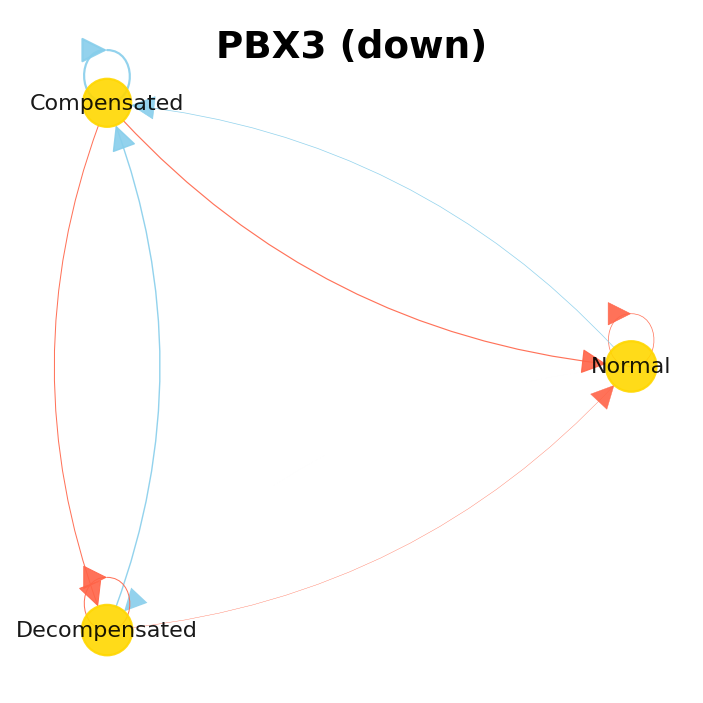

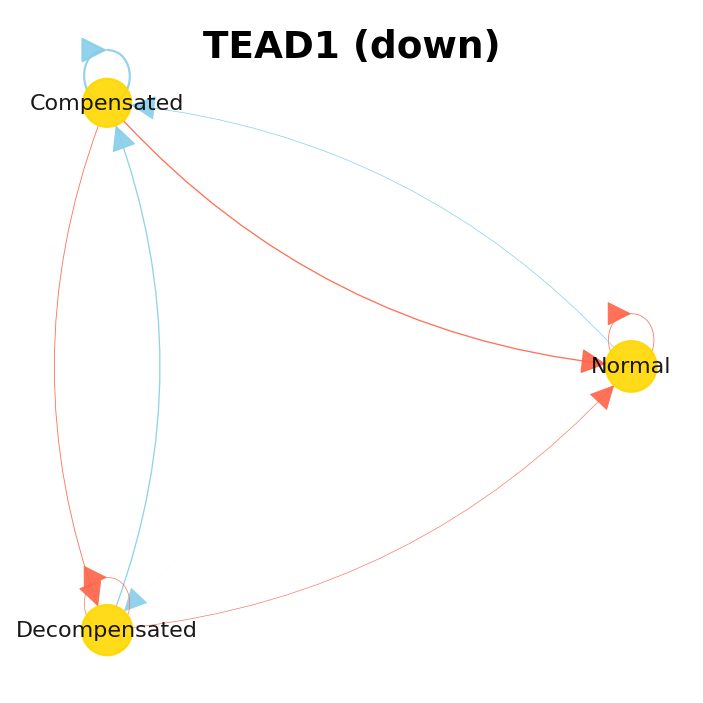

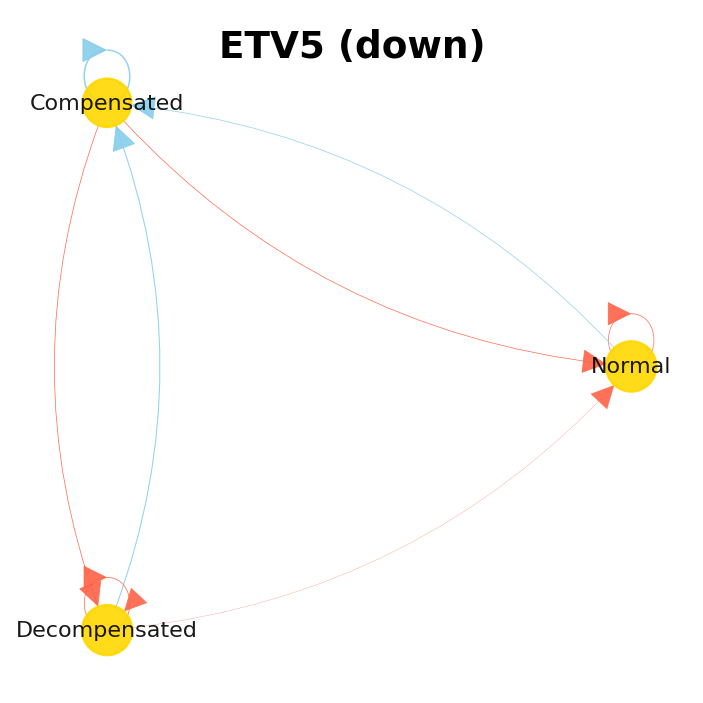

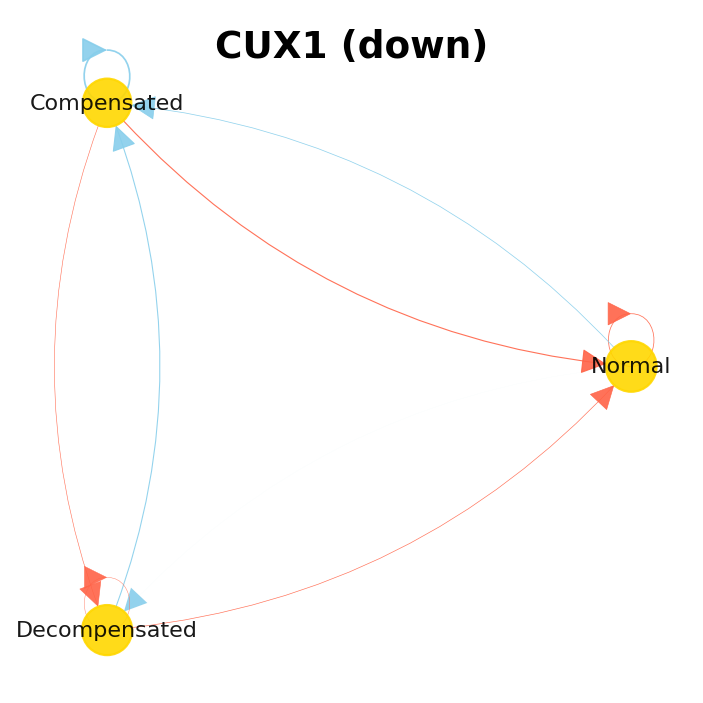

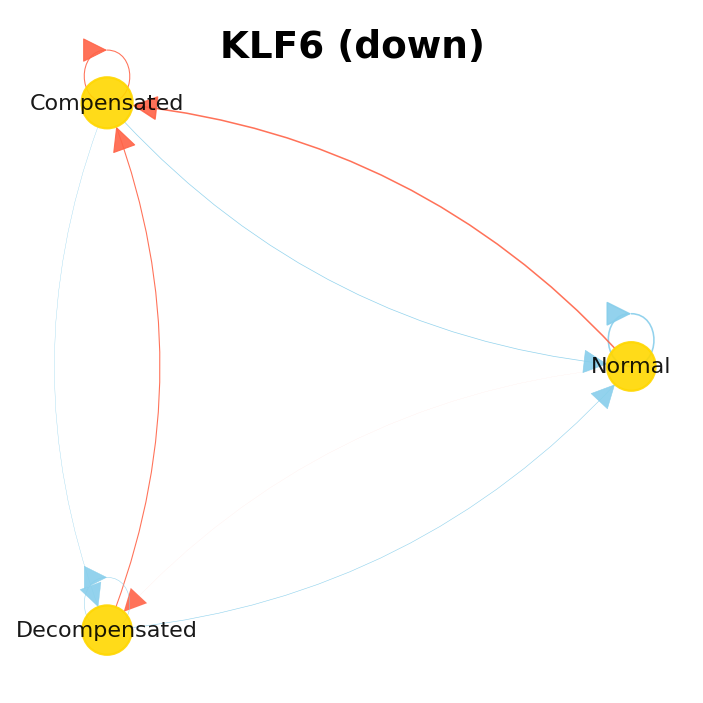

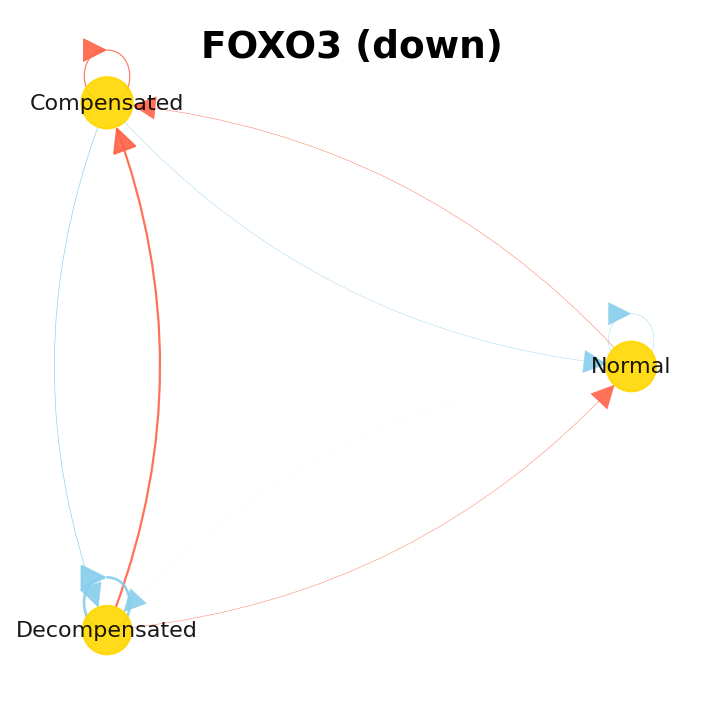

In [20]:
cls = {0:'Non-diabetic', 1:'Pre-T2D', 2:'T2D'}

rep = 0
cells = results[rep, :, :, :]
inds = top_tfs_ind
rank = 1
for ind in inds:
    mat = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            mat[i, j] = np.mean(cells[np.array(y_label_test)==cls[i], ind, j])

    tf = tfs_kept[ind]

    import matplotlib.pyplot as plt
    import networkx as nx
    plt.figure(figsize=(4.2,4.2))
    #plt.gcf().set_size_inches(5, 5)
    G = nx.DiGraph()
    states = ['Normal', 'Compensated', 'Decompensated']
    G.add_nodes_from(states)

    # 添加带权重的边，权重代表转移概率
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            G.add_edge(states[i], states[j], weight=mat[i,j])

    # 获取边的权重值和颜色
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    edge_colors = ['tomato' if weight >= 0 else 'skyblue' for weight in edge_weights]
    width = [abs(weight)*30 for weight in edge_weights]
    node_size=[np.sum(mat[i,:] + mat[:,i]) for i in range(3)]

    # 定义节点颜色
    node_colors = ['gold' for state in G.nodes]

    # 绘制图形
    pos = nx.circular_layout(G, scale=1)
    nx.draw(G, pos, with_labels=True, 
            node_color=node_colors, 
            node_size = [500*i+500 for i in node_size],
            width=width, 
            edge_color=edge_colors, connectionstyle="arc3,rad=0.2",
            font_size=10, font_color='black', alpha=0.9, arrowsize=25)

    plt.suptitle(tf+' (down)', fontweight='bold')
    plt.savefig('/nfs/public/xixi/scRegulate/figures/supp_fig2/'+str(rank)+'_'+tf+'.pdf')
    plt.show()
    plt.close()
    rank += 1

# pdCRE prioritization

In [ ]:
h5f = h5py.File('./predict_status_resplit/data_T2D_float16_resplit.h5', 'r')
num_peaks = h5f['num_peaks'][:]
h5f.close()

cut = [0]
s = 0
for i in num_peaks:
    s = s+i
    cut.append(s)

In [23]:
files = os.listdir('/nfs/public/xixi/scRegulate/T2D/nn.best.feature6.learnW')
markers_filtered = []
for file in files:
    if len(file.split('.2.pt'))>1:
        marker = file.split('.2.pt')[0]
        if marker not in markers_filtered:
            markers_filtered.append(marker)

markers = pd.read_csv("./data/markers_status.txt", sep='\t')
markers = markers.groupby('cluster').apply(lambda x: x.nlargest(100, 'avg_log2FC')).reset_index(drop=True)
markers = markers['gene'].drop_duplicates().to_list()

genes_filtered = [i for i in markers_filtered if i not in tfs_kept]
genes_filtered = [i for i in genes_filtered if i in markers]
print(len(genes_filtered))

239


In [24]:
percent = 0.05
results = np.load('./predict_status/interpret/input_output_openness_all1_GCN.string.npy')
h5f = h5py.File('./predict_status/data_T2D_float16.h5', 'r')
peaks = pd.DataFrame(np.array([item.decode('utf-8') for j in h5f['peaks'][:] for item in j]).reshape(-1, 3))
h5f.close()
import scipy.stats as ss
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(peaks))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = int(percent*len(peaks))
top_peaks_ind = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest

results = np.load('./predict_status/interpret/input_output_openness*0_GCN.string.npy')
#results_orig = np.load('./predict_status/interpret/input_output_openness*0_orig_GCN.string.npy')
#results_perturb = np.load('./predict_status/interpret/input_output_openness*0_perturb_GCN.string.npy')
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(peaks))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = int(percent*len(peaks))
top_peaks_ind0 = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest
print(top)
print(len(set(top_peaks_ind).intersection(set(top_peaks_ind0))))
print(len(set(top_peaks_ind).intersection(set(top_peaks_ind0)))/top)

1259
1015
0.8061953931691819


In [25]:
top_peaks_ind = list(top_peaks_ind)+list(top_peaks_ind0)
top_peaks_ind = list(pd.DataFrame(top_peaks_ind).drop_duplicates()[0])

marker_peaks = []
markers_ = []
_peaks = []
df_bed = pd.DataFrame()
for i in top_peaks_ind:
    for marker_ind in range(len(cut)):
        if i>=cut[marker_ind] and i<cut[marker_ind+1]:
            break
    marker = genes_filtered[marker_ind]
    markers_.append(marker)
    df_bed = df_bed.append(peaks.iloc[i, :])
    peak = str(peaks.iloc[i, 0])+':'+str(peaks.iloc[i, 1])+'-'+str(peaks.iloc[i, 2])
    
    _peaks.append(peak)
    feature = marker + '::' + peak
    marker_peaks.append(feature)
df_bed = df_bed.drop_duplicates().reset_index(drop=True)
df_bed

,0,1,2
0,chr9,94664770,94665270
1,chr9,94914257,94914757
2,chr9,94671007,94671507
3,chr9,94558673,94559173
4,chr9,94660876,94661376
...,...,...,...
1404,chr5,138145582,138146082
1405,chr6,53950266,53950766
1406,chr5,137872322,137872822
1407,chr8,6473778,6474278
